<a href="https://colab.research.google.com/github/PranjalAyare/Song_genre_classifier/blob/main/song_genre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First things first... let's create our PySpark instance.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pyspark

In [ ]:
# import findspark
# findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
# May take awhile locally
spark = SparkSession.builder.appName("ClassificationPS").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

You are working with 1 core(s)


In [ ]:
# Read in dependencies
from pyspark.ml.feature import VectorAssembler, StringIndexer, MinMaxScaler
from pyspark.sql.types import *

from pyspark.ml.classification import *
from pyspark.ml.evaluation import *
from pyspark.sql.functions import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

Read in our dataset


In [ ]:
path = "/content/beatsdataset.csv"
df = spark.read.csv(path, inferSchema=True, header=True)


### Check out the dataset

Let's produce a print out of the dataframe so we know what we are working with.

In [ ]:
df.limit(6).toPandas()

,_c0,1-ZCRm,2-Energym,3-EnergyEntropym,4-SpectralCentroidm,5-SpectralSpreadm,6-SpectralEntropym,7-SpectralFluxm,8-SpectralRolloffm,9-MFCCs1m,...,63-ChromaVector8std,64-ChromaVector9std,65-ChromaVector10std,66-ChromaVector11std,67-ChromaVector12std,68-ChromaDeviationstd,69-BPM,70-BPMconf,71-BPMessentia,class
0,0,0.136440,0.088861,3.201201,0.262825,0.249212,1.114423,0.007003,0.256682,-22.723259,...,0.003431,0.004981,0.010818,0.024001,0.005201,0.015056,133.333333,0.132792,128.0,BigRoom
1,1,0.117039,0.108389,3.194001,0.247657,0.250288,1.065668,0.005387,0.199821,-21.775871,...,0.004461,0.006441,0.007469,0.015499,0.005589,0.019339,120.000000,0.112767,126.0,BigRoom
2,2,0.085308,0.128525,3.123837,0.217205,0.228652,0.789647,0.008247,0.156822,-22.472722,...,0.001529,0.004556,0.007723,0.017482,0.002901,0.022201,133.333333,0.123373,129.0,BigRoom
3,3,0.103050,0.167042,3.150830,0.233593,0.245032,0.967082,0.006571,0.168083,-21.470751,...,0.001591,0.003514,0.009477,0.023162,0.004165,0.015379,133.333333,0.158876,129.0,BigRoom
4,4,0.151730,0.148405,3.194498,0.293730,0.267231,1.353005,0.003872,0.292055,-21.371157,...,0.003945,0.004131,0.011330,0.028188,0.002639,0.019079,133.333333,0.190708,129.0,BigRoom
5,5,0.127047,0.153488,3.221987,0.261693,0.257361,1.090034,0.004943,0.230099,-21.234846,...,0.002986,0.006533,0.010347,0.025008,0.003035,0.019479,133.333333,0.168933,129.0,BigRoom


In [ ]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- 1-ZCRm: double (nullable = true)
 |-- 2-Energym: double (nullable = true)
 |-- 3-EnergyEntropym: double (nullable = true)
 |-- 4-SpectralCentroidm: double (nullable = true)
 |-- 5-SpectralSpreadm: double (nullable = true)
 |-- 6-SpectralEntropym: double (nullable = true)
 |-- 7-SpectralFluxm: double (nullable = true)
 |-- 8-SpectralRolloffm: double (nullable = true)
 |-- 9-MFCCs1m: double (nullable = true)
 |-- 10-MFCCs2m: double (nullable = true)
 |-- 11-MFCCs3m: double (nullable = true)
 |-- 12-MFCCs4m: double (nullable = true)
 |-- 13-MFCCs5m: double (nullable = true)
 |-- 14-MFCCs6m: double (nullable = true)
 |-- 15-MFCCs7m: double (nullable = true)
 |-- 16-MFCCs8m: double (nullable = true)
 |-- 17-MFCCs9m: double (nullable = true)
 |-- 18-MFCCs10m: double (nullable = true)
 |-- 19-MFCCs11m: double (nullable = true)
 |-- 20-MFCCs12m: double (nullable = true)
 |-- 21-MFCCs13m: double (nullable = true)
 |-- 22-ChromaVector1m: double (null

We have a perfectly balanced dataset, however we only have 100 examples from each class which may make training a decent model challenging. But let's see what we can do!

In [ ]:
df.groupBy("class").count().show(100)

+--------------------+-----+
|               class|count|
+--------------------+-----+
|           PsyTrance|  100|
|           HardDance|  100|
|              Breaks|  100|
|  HardcoreHardTechno|  100|
|   IndieDanceNuDisco|  100|
|              Trance|  100|
|           DeepHouse|  100|
|ElectronicaDowntempo|  100|
|           ReggaeDub|  100|
|             Minimal|  100|
|         DrumAndBass|  100|
|             Dubstep|  100|
|             BigRoom|  100|
|              Techno|  100|
|               House|  100|
|         FutureHouse|  100|
|        ElectroHouse|  100|
|           GlitchHop|  100|
|           TechHouse|  100|
|              HipHop|  100|
|           FunkRAndB|  100|
|               Dance|  100|
|    ProgressiveHouse|  100|
+--------------------+-----+



## Set up our Data Formatting Function

MLlib requires all input columns of your dataframe to be vectorized and our dependent variable needs to be zero indexed. We can do that using our handy dandy function we developed in the lecture.

For example, with this go, I added a print statement to show the new label values for each class.

In [ ]:
# Data Prep function
def MLClassifierDFPrep(df,input_columns,dependent_var,treat_outliers=True,treat_neg_values=True):

    # change label (class variable) to string type to prep for reindexing
    # Pyspark is expecting a zero indexed integer for the label column.
    # Just incase our data is not in that format... we will treat it by using the StringIndexer built in method
    renamed = df.withColumn("label_str", df[dependent_var].cast(StringType())) #Rename and change to string type
    indexer = StringIndexer(inputCol="label_str", outputCol="label") #Pyspark is expecting the this naming convention
    indexed = indexer.fit(renamed).transform(renamed)
    print(indexed.groupBy("class","label").count().show(100))

    # Convert all string type data in the input column list to numeric
    # Otherwise the Algorithm will not be able to process it
    numeric_inputs = []
    string_inputs = []
    for column in input_columns:
        if str(indexed.schema[column].dataType) == 'StringType':
            indexer = StringIndexer(inputCol=column, outputCol=column+"_num")
            indexed = indexer.fit(indexed).transform(indexed)
            new_col_name = column+"_num"
            string_inputs.append(new_col_name)
        else:
            numeric_inputs.append(column)

    if treat_outliers == True:
        print("We are correcting for non normality now!")
        # empty dictionary d
        d = {}
        # Create a dictionary of quantiles
        for col in numeric_inputs:
            d[col] = indexed.approxQuantile(col,[0.01,0.99],0.25) #if you want to make it go faster increase the last number
        #Now fill in the values
        for col in numeric_inputs:
            skew = indexed.agg(skewness(indexed[col])).collect() #check for skewness
            skew = skew[0][0]
            # This function will floor, cap and then log+1 (just in case there are 0 values)
            if skew > 1:
                indexed = indexed.withColumn(col, \
                log(when(df[col] < d[col][0],d[col][0])\
                .when(indexed[col] > d[col][1], d[col][1])\
                .otherwise(indexed[col] ) +1).alias(col))
                print(col+" has been treated for positive (right) skewness. (skew =)",skew,")")
            elif skew < -1:
                indexed = indexed.withColumn(col, \
                exp(when(df[col] < d[col][0],d[col][0])\
                .when(indexed[col] > d[col][1], d[col][1])\
                .otherwise(indexed[col] )).alias(col))
                print(col+" has been treated for negative (left) skewness. (skew =",skew,")")


    # Produce a warning if there are negative values in the dataframe that Naive Bayes cannot be used.
    # Note: we only need to check the numeric input values since anything that is indexed won't have negative values
    minimums = df.select([min(c).alias(c) for c in df.columns if c in numeric_inputs]) # Calculate the mins for all columns in the df
    min_array = minimums.select(array(numeric_inputs).alias("mins")) # Create an array for all mins and select only the input cols
    df_minimum = min_array.select(array_min(min_array.mins)).collect() # Collect golobal min as Python object
    df_minimum = df_minimum[0][0] # Slice to get the number itself

    features_list = numeric_inputs + string_inputs
    assembler = VectorAssembler(inputCols=features_list,outputCol='features')
    output = assembler.transform(indexed).select('features','label')

#     final_data = output.select('features','label') #drop everything else

    # Now check for negative values and ask user if they want to correct that?
    if df_minimum < 0:
        print(" ")
        print("WARNING: The Naive Bayes Classifier will not be able to process your dataframe as it contains negative values")
        print(" ")

    if treat_neg_values == True:
        print("You have opted to correct that by rescaling all your features to a range of 0 to 1")
        print(" ")
        print("We are rescaling you dataframe....")
        scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

        # Compute summary statistics and generate MinMaxScalerModel
        scalerModel = scaler.fit(output)

        # rescale each feature to range [min, max].
        scaled_data = scalerModel.transform(output)
        final_data = scaled_data.select('label','scaledFeatures') # added class to the selection
        final_data = final_data.withColumnRenamed('scaledFeatures','features')
        print("Done!")

    else:
        print("You have opted not to correct that therefore you will not be able to use to Naive Bayes classifier")
        print("We will return the dataframe unscaled.")
        final_data = output

    return final_data

## Set up our Training and Evaluation Function
1. You'll see in the area where we print our coefficients and feature importances values, that I created a new output format that joins the values with their corresponding feature names so we can clearly see which value belongs to which feature. I did this by zipping the lists together and creating a Spark dataframe to allow the output to be viewed in column row format as opposed to a messy list.
2. The second change I added was a parameter for the folds so that I could specify the folds more easily with each iteration.


In [ ]:
def ClassTrainEval(classifier,features,classes,folds,train,test):

    def FindMtype(classifier):
        # Intstantiate Model
        M = classifier
        # Learn what it is
        Mtype = type(M).__name__

        return Mtype

    Mtype = FindMtype(classifier)


    def IntanceFitModel(Mtype,classifier,classes,features,folds,train):

        if Mtype == "OneVsRest":
            # instantiate the base classifier.
            lr = LogisticRegression()
            # instantiate the One Vs Rest Classifier.
            OVRclassifier = OneVsRest(classifier=lr)
#             fitModel = OVRclassifier.fit(train)
            # Add parameters of your choice here:
            paramGrid = ParamGridBuilder() \
                .addGrid(lr.regParam, [0.1, 0.01]) \
                .build()
            #Cross Validator requires the following parameters:
            crossval = CrossValidator(estimator=OVRclassifier,
                                      estimatorParamMaps=paramGrid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=folds) # 3 is best practice
            # Run cross-validation, and choose the best set of parameters.
            fitModel = crossval.fit(train)
            return fitModel
        if Mtype == "MultilayerPerceptronClassifier":
            # specify layers for the neural network:
            # input layer of size features, two intermediate of features+1 and same size as features
            # and output of size number of classes
            # Note: crossvalidator cannot be used here
            features_count = len(features[0][0])
            layers = [features_count, features_count+1, features_count, classes]
            MPC_classifier = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)
            fitModel = MPC_classifier.fit(train)
            return fitModel
        if Mtype in("LinearSVC","GBTClassifier") and classes != 2: # These classifiers currently only accept binary classification
            print(Mtype," could not be used because PySpark currently only accepts binary classification data for this algorithm")
            return
        if Mtype in("LogisticRegression","NaiveBayes","RandomForestClassifier","GBTClassifier","LinearSVC","DecisionTreeClassifier"):

            # Add parameters of your choice here:
            if Mtype in("LogisticRegression"):
                paramGrid = (ParamGridBuilder() \
#                              .addGrid(classifier.regParam, [0.1, 0.01]) \
                             .addGrid(classifier.maxIter, [10, 15,20])
                             .build())

            # Add parameters of your choice here:
            if Mtype in("NaiveBayes"):
                paramGrid = (ParamGridBuilder() \
                             .addGrid(classifier.smoothing, [0.0, 0.2, 0.4, 0.6]) \
                             .build())

            # Add parameters of your choice here:
            if Mtype in("RandomForestClassifier"):
                paramGrid = (ParamGridBuilder() \
                               .addGrid(classifier.maxDepth, [2, 5, 10])
#                                .addGrid(classifier.maxBins, [5, 10, 20])
#                                .addGrid(classifier.numTrees, [5, 20, 50])
                             .build())

            # Add parameters of your choice here:
            if Mtype in("GBTClassifier"):
                paramGrid = (ParamGridBuilder() \
#                              .addGrid(classifier.maxDepth, [2, 5, 10, 20, 30]) \
#                              .addGrid(classifier.maxBins, [10, 20, 40, 80, 100]) \
                             .addGrid(classifier.maxIter, [10, 15,50,100])
                             .build())

            # Add parameters of your choice here:
            if Mtype in("LinearSVC"):
                paramGrid = (ParamGridBuilder() \
                             .addGrid(classifier.maxIter, [10, 15]) \
                             .addGrid(classifier.regParam, [0.1, 0.01]) \
                             .build())

            # Add parameters of your choice here:
            if Mtype in("DecisionTreeClassifier"):
                paramGrid = (ParamGridBuilder() \
#                              .addGrid(classifier.maxDepth, [2, 5, 10, 20, 30]) \
                             .addGrid(classifier.maxBins, [10, 20, 40, 80, 100]) \
                             .build())

            #Cross Validator requires all of the following parameters:
            crossval = CrossValidator(estimator=classifier,
                                      estimatorParamMaps=paramGrid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=folds) # 3 + is best practice
            # Fit Model: Run cross-validation, and choose the best set of parameters.
            fitModel = crossval.fit(train)
            return fitModel

    fitModel = IntanceFitModel(Mtype,classifier,classes,features,folds,train)

    # Print feature selection metrics
    if fitModel is not None:

        if Mtype in("OneVsRest"):
            # Get Best Model
            BestModel = fitModel.bestModel
            global OVR_BestModel
            OVR_BestModel = BestModel
            print(" ")
            print('\033[1m' + Mtype + '\033[0m')
            # Extract list of binary models
            models = BestModel.models
            for model in models:
                print('\033[1m' + 'Intercept: '+ '\033[0m',model.intercept)
                print('\033[1m' + 'Top 20 Coefficients:'+ '\033[0m')
                coeff_array = model.coefficients.toArray()
                coeff_scores = []
                for x in coeff_array:
                    coeff_scores.append(float(x))
                # Then zip with input_columns list and create a df
                result = spark.createDataFrame(zip(input_columns,coeff_scores), schema=['feature','coeff'])
                print(result.orderBy(result["coeff"].desc()).show(truncate=False))


        if Mtype == "MultilayerPerceptronClassifier":
            print("")
            print('\033[1m' + Mtype + '\033[0m')
            print('\033[1m' + "Model Weights: "+ '\033[0m',fitModel.weights.size)
            print("")
            global MLPC_Model
            MLPC_BestModel = fitModel

        if Mtype in("DecisionTreeClassifier", "GBTClassifier","RandomForestClassifier"):
            # FEATURE IMPORTANCES
            # Estimate of the importance of each feature.
            # Each feature’s importance is the average of its importance across all trees
            # in the ensemble The importance vector is normalized to sum to 1.
            # Get Best Model
            BestModel = fitModel.bestModel
            print(" ")
            print('\033[1m' + Mtype," Top 20 Feature Importances"+ '\033[0m')
            print("(Scores add up to 1)")
            print("Lowest score is the least important")
            print(" ")
            featureImportances = BestModel.featureImportances.toArray()
            # Convert from numpy array to list
            imp_scores = []
            for x in featureImportances:
                imp_scores.append(float(x))
            # Then zip with input_columns list and create a df
            result = spark.createDataFrame(zip(input_columns,imp_scores), schema=['feature','score'])
            print(result.orderBy(result["score"].desc()).show(truncate=False))

            # Save the feature importance values and the models
            if Mtype in("DecisionTreeClassifier"):
                global DT_featureimportances
                DT_featureimportances = BestModel.featureImportances.toArray()
                global DT_BestModel
                DT_BestModel = BestModel
            if Mtype in("GBTClassifier"):
                global GBT_featureimportances
                GBT_featureimportances = BestModel.featureImportances.toArray()
                global GBT_BestModel
                GBT_BestModel = BestModel
            if Mtype in("RandomForestClassifier"):
                global RF_featureimportances
                RF_featureimportances = BestModel.featureImportances.toArray()
                global RF_BestModel
                RF_BestModel = BestModel

        # Print the coefficients
        if Mtype in("LogisticRegression"):
            # Get Best Model
            BestModel = fitModel.bestModel
            print(" ")
            print('\033[1m' + Mtype + '\033[0m')
            print("Intercept: " + str(BestModel.interceptVector))
            print('\033[1m' + " Top 20 Coefficients"+ '\033[0m')
            print("You should compares these relative to eachother")
            # Convert from numpy array to list
            coeff_array = BestModel.coefficientMatrix.toArray()
            coeff_scores = []
            for x in coeff_array[0]:
                coeff_scores.append(float(x))
            # Then zip with input_columns list and create a df
            result = spark.createDataFrame(zip(input_columns,coeff_scores), schema=['feature','coeff'])
            print(result.orderBy(result["coeff"].desc()).show(truncate=False))
            # Save the coefficient values and the models
            global LR_coefficients
            LR_coefficients = BestModel.coefficientMatrix.toArray()
            global LR_BestModel
            LR_BestModel = BestModel

        # Print the Coefficients
        if Mtype in("LinearSVC"):
            # Get Best Model
            BestModel = fitModel.bestModel
            print(" ")
            print('\033[1m' + Mtype + '\033[0m')
            print("Intercept: " + str(BestModel.intercept))
            print('\033[1m' + "Top 20 Coefficients"+ '\033[0m')
            print("You should compares these relative to eachother")
#             print("Coefficients: \n" + str(BestModel.coefficients))
            coeff_array = BestModel.coefficients.toArray()
            coeff_scores = []
            for x in coeff_array:
                coeff_scores.append(float(x))
            # Then zip with input_columns list and create a df
            result = spark.createDataFrame(zip(input_columns,coeff_scores), schema=['feature','coeff'])
            print(result.orderBy(result["coeff"].desc()).show(truncate=False))
            # Save the coefficient values and the models
            global LSVC_coefficients
            LSVC_coefficients = BestModel.coefficients.toArray()
            global LSVC_BestModel
            LSVC_BestModel = BestModel


    # Set the column names to match the external results dataframe that we will join with later:
    columns = ['Classifier', 'Result']

    if Mtype in("LinearSVC","GBTClassifier") and classes != 2:
        Mtype = [Mtype] # make this a list
        score = ["N/A"]
        result = spark.createDataFrame(zip(Mtype,score), schema=columns)
    else:
        predictions = fitModel.transform(test)
        MC_evaluator = MulticlassClassificationEvaluator(metricName="accuracy") # redictionCol="prediction",
        accuracy = (MC_evaluator.evaluate(predictions))*100
        Mtype = [Mtype] # make this a string
        score = [str(accuracy)] #make this a string and convert to a list
        result = spark.createDataFrame(zip(Mtype,score), schema=columns)
        result = result.withColumn('Result',result.Result.substr(0, 5))

    return result
    #Also returns the fit model important scores or p values

## Testing Time!

Now we can use these functions above to train and evaluate our models in different ways.

In [ ]:
# Set up independ and dependent vars
input_columns = df.columns
input_columns = input_columns[1:-1] # keep only relevant columns: everything but the first and last cols
dependent_var = 'class'

# Learn how many classes there are in order to specify evaluation type based on binary or multi and turn the df into an object
class_count = df.select(countDistinct("class")).collect()
classes = class_count[0][0]

### Test 1: Without outlier treatment, skew or negative value treatment

This first go will act as our baseline so we can understand how our treatments affected our analysis. So I will opt out of the option for outlier treatment, skew treatment or negative value treatment which means we cannot use the naive bayes classifier.

In [ ]:
# Call on data prep, train and evaluate functions
test1_data = MLClassifierDFPrep(df,input_columns,dependent_var,treat_outliers=False,treat_neg_values=False)
test1_data.limit(5).toPandas()

# Comment out Naive Bayes if your data still contains negative values
classifiers = [
                LogisticRegression()
                ,OneVsRest()
               ,LinearSVC()
#                ,NaiveBayes()
               ,RandomForestClassifier()
               ,GBTClassifier()
               ,DecisionTreeClassifier()
               ,MultilayerPerceptronClassifier()
              ]

train,test = test1_data.randomSplit([0.7,0.3])
features = test1_data.select(['features']).collect()
folds = 2 # because we have limited data

#set up your results table
columns = ['Classifier', 'Result']
vals = [("Place Holder","N/A")]
results = spark.createDataFrame(vals, columns)

for classifier in classifiers:
    new_result = ClassTrainEval(classifier,features,classes,folds,train,test)
    results = results.union(new_result)
results = results.where("Classifier!='Place Holder'")
print("!!!!!Final Results!!!!!!!!")
results.show(100,False)

+--------------------+-----+-----+
|               class|label|count|
+--------------------+-----+-----+
|           ReggaeDub| 19.0|  100|
|           FunkRAndB|  8.0|  100|
|              Trance| 22.0|  100|
|              Techno| 21.0|  100|
|             Dubstep|  5.0|  100|
|   IndieDanceNuDisco| 15.0|  100|
|ElectronicaDowntempo|  7.0|  100|
|               House| 14.0|  100|
|  HardcoreHardTechno| 12.0|  100|
|              HipHop| 13.0|  100|
|           GlitchHop| 10.0|  100|
|         DrumAndBass|  4.0|  100|
|           PsyTrance| 18.0|  100|
|    ProgressiveHouse| 17.0|  100|
|        ElectroHouse|  6.0|  100|
|           HardDance| 11.0|  100|
|             Minimal| 16.0|  100|
|           TechHouse| 20.0|  100|
|           DeepHouse|  3.0|  100|
|             BigRoom|  0.0|  100|
|         FutureHouse|  9.0|  100|
|               Dance|  2.0|  100|
|              Breaks|  1.0|  100|
+--------------------+-----+-----+

None
 
 
You have opted not to correct that therefore 

### Test 2: Test treatments

Train and evaluate models on treated data (outliers, skewness and negative values) and compare to baseline (#1).

In [ ]:
# Call on data prep, train and evaluate functions
test2_data = MLClassifierDFPrep(df,input_columns,dependent_var,treat_outliers=True,treat_neg_values=True)
test2_data.limit(5).toPandas()

# Comment out Naive Bayes if your data still contains negative values
classifiers = [
                LogisticRegression()
                ,OneVsRest()
               ,LinearSVC()
               ,NaiveBayes()
               ,RandomForestClassifier()
               ,GBTClassifier()
               ,DecisionTreeClassifier()
               ,MultilayerPerceptronClassifier()
              ]

train,test = test2_data.randomSplit([0.7,0.3])
features = test2_data.select(['features']).collect()
folds = 2

#set up your results table
columns = ['Classifier', 'Result']
vals = [("Place Holder","N/A")]
results = spark.createDataFrame(vals, columns)

for classifier in classifiers:
    new_result = ClassTrainEval(classifier,features,classes,folds,train,test)
    results = results.union(new_result)
results = results.where("Classifier!='Place Holder'")
print("!!!!!Final Results!!!!!!!!")
results.show(100,False)

+--------------------+-----+-----+
|               class|label|count|
+--------------------+-----+-----+
|           ReggaeDub| 19.0|  100|
|           FunkRAndB|  8.0|  100|
|              Trance| 22.0|  100|
|              Techno| 21.0|  100|
|             Dubstep|  5.0|  100|
|   IndieDanceNuDisco| 15.0|  100|
|ElectronicaDowntempo|  7.0|  100|
|               House| 14.0|  100|
|  HardcoreHardTechno| 12.0|  100|
|              HipHop| 13.0|  100|
|           GlitchHop| 10.0|  100|
|         DrumAndBass|  4.0|  100|
|           PsyTrance| 18.0|  100|
|    ProgressiveHouse| 17.0|  100|
|        ElectroHouse|  6.0|  100|
|           HardDance| 11.0|  100|
|             Minimal| 16.0|  100|
|           TechHouse| 20.0|  100|
|           DeepHouse|  3.0|  100|
|             BigRoom|  0.0|  100|
|         FutureHouse|  9.0|  100|
|               Dance|  2.0|  100|
|              Breaks|  1.0|  100|
+--------------------+-----+-----+

None
We are correcting for non normality now!
7-Spectr

## Test 3: Feature Selection

Looks like all our of our models saw a little bit of improvement from the transformations we applied. And overall the best performing model was the One vs Rest. Let's try to do do some feature selection to make it even better!

Since we are using the One vs Rest algorithm backed by Logistic Regression, we can use Pyspark's Chi Squared Selector feature to select our features.


In [ ]:
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors

classifiers = [OneVsRest()]

#Select the top n features and view results
maximum = len(input_columns)
for n in range(10,maximum,10):
    print("Testing top n = ",n," features")

    # For Tree classifiers
#     best_n_features = RF_featureimportances.argsort()[-n:][::-1]
#     best_n_features= best_n_features.tolist() # convert to a list
#     vs = VectorSlicer(inputCol="features", outputCol="best_features", indices=best_n_features)
#     bestFeaturesDf = vs.transform(test2_data)

    # For Logistic regression or One vs Rest
    selector = ChiSqSelector(numTopFeatures=n, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="label")
    bestFeaturesDf = selector.fit(test2_data).transform(test2_data)
    bestFeaturesDf = bestFeaturesDf.select("label","selectedFeatures")
    bestFeaturesDf = bestFeaturesDf.withColumnRenamed("selectedFeatures","features")

    # Collect features
    features = bestFeaturesDf.select(['features']).collect()

    # Split
    train,test = bestFeaturesDf.randomSplit([0.7,0.3])

    # Specify folds
    folds = 2

    #set up your results table
    columns = ['Classifier', 'Result']
    vals = [("Place Holder","N/A")]
    results = spark.createDataFrame(vals, columns)

    for classifier in classifiers:
        new_result = ClassTrainEval(classifier,features,classes,folds,train,test)
        results = results.union(new_result)
    results = results.where("Classifier!='Place Holder'")
    results.show(100,False)

Testing top n =  10  features
 
OneVsRest
Intercept:  -0.08896097941846604
Top 20 Coefficients:
+-------------------+-------------------+
|feature            |coeff              |
+-------------------+-------------------+
|10-MFCCs2m         |2.53202545101455   |
|8-SpectralRolloffm |0.6054703784662889 |
|2-Energym          |0.5067963508925463 |
|3-EnergyEntropym   |0.47654846505130266|
|1-ZCRm             |-0.8420179666679622|
|7-SpectralFluxm    |-1.3908633383306714|
|6-SpectralEntropym |-2.3842055456585656|
|9-MFCCs1m          |-2.663122843563915 |
|4-SpectralCentroidm|-3.8220261873338366|
|5-SpectralSpreadm  |-5.523295419218042 |
+-------------------+-------------------+

None
Intercept:  -4.875660959197879
Top 20 Coefficients:
+-------------------+--------------------+
|feature            |coeff               |
+-------------------+--------------------+
|9-MFCCs1m          |4.468832564680387   |
|10-MFCCs2m         |2.5632225799569763  |
|4-SpectralCentroidm|0.46449857092064273 |


# Results

Let's see if we can improve upon the results above of 45.94%.

- 10 features = 32.27% (going down)
- 20 features = 39.23% (going down)
- 30 features = 39.24% (going down)
- 40 features = 42.61% (going down)
- 50 features = 43.52% (going down)
- 60 features = 42.42% (going down)
- 70 features = 40.22% (going down)

**Take away:** looks like we actually never beat our baseline so let's stick with the 71 features. Setting a random seed might have helped with variability we saw here.

## Train final model

Now we can finally train our final model with the optimal set of features!

In [ ]:
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors

classifiers = [OneVsRest()]

#Select the top n features and view results
n = 71

# For Logistic regression or One vs Rest
selector = ChiSqSelector(numTopFeatures=n, featuresCol="features",
                     outputCol="selectedFeatures", labelCol="label")
bestFeaturesDf = selector.fit(test2_data).transform(test2_data)
bestFeaturesDf = bestFeaturesDf.select("label","selectedFeatures")
bestFeaturesDf = bestFeaturesDf.withColumnRenamed("selectedFeatures","features")

# Collect features
features = bestFeaturesDf.select(['features']).collect()

# Split
train,test = bestFeaturesDf.randomSplit([0.7,0.3])

# Specify folds
folds = 2

#set up your results table
columns = ['Classifier', 'Result']
vals = [("Place Holder","N/A")]
results = spark.createDataFrame(vals, columns)

for classifier in classifiers:
    new_result = ClassTrainEval(classifier,features,classes,folds,train,test)
    results = results.union(new_result)
results = results.where("Classifier!='Place Holder'")
results.show(100,False)

 
OneVsRest
Intercept:  -3.9609522490914397
Top 20 Coefficients:
+-------------------+------------------+
|feature            |coeff             |
+-------------------+------------------+
|9-MFCCs1m          |4.115931693031662 |
|18-MFCCs10m        |1.9997082071436425|
|53-MFCCs11std      |1.8266192164031925|
|71-BPMessentia     |1.789096950824824 |
|22-ChromaVector1m  |1.6390461656335853|
|3-EnergyEntropym   |1.4868353124267555|
|24-ChromaVector3m  |1.4357851976439988|
|5-SpectralSpreadm  |1.3544133655227597|
|27-ChromaVector6m  |1.2975333559947824|
|43-MFCCs1std       |1.2749069282112553|
|50-MFCCs8std       |1.2434166969351022|
|12-MFCCs4m         |1.2189575432490123|
|54-MFCCs12std      |1.1746764554556792|
|2-Energym          |1.1537081848835549|
|52-MFCCs10std      |0.9065058386557744|
|57-ChromaVector2std|0.6983222411371932|
|33-ChromaVector12m |0.6515053999393854|
|58-ChromaVector3std|0.6081746851556376|
|14-MFCCs6m         |0.5378616888684496|
|15-MFCCs7m         |0.5341892907

## Make a recommendation to a user!

Imagine that your new model is being deployed in the next version release of the online radio station that has now purchased this model from you. So the existing users have gotten used to the songs in certian stations but now your model may be adding new songs to those stations.

In [ ]:
predictions = OVR_BestModel.transform(test)

In [ ]:
# From the output earlier we saw that the new label for BigRoom is now 21.0
# Let's get a song from there
count = predictions.filter("label!=21.0 AND prediction == 21.0").count()
print(count)
predictions.filter("label!=21.0 AND prediction == 21.0").show()
# predictions.show()

18
+-----+--------------------+--------------------+----------+
|label|            features|       rawPrediction|prediction|
+-----+--------------------+--------------------+----------+
|  3.0|[0.26893476388404...|[-6.5280883956051...|      21.0|
|  6.0|[0.36117260545393...|[-2.4994776279541...|      21.0|
|  7.0|[0.03332259741112...|[-5.7891788730997...|      21.0|
| 12.0|[0.23137556639909...|[-5.4124744100131...|      21.0|
| 14.0|[0.39093804361554...|[-4.0329905130600...|      21.0|
| 14.0|[0.45881424267998...|[-4.4131709650857...|      21.0|
| 15.0|[0.35925721867944...|[-6.8251629653132...|      21.0|
| 16.0|[0.22418634208614...|[-6.2082315353446...|      21.0|
| 16.0|[0.24539933945898...|[-7.3541734503478...|      21.0|
| 16.0|[0.24582293877877...|[-4.0125006017178...|      21.0|
| 16.0|[0.36447028193982...|[-7.8838414853605...|      21.0|
| 16.0|[0.41147090658857...|[-6.9065731702937...|      21.0|
| 16.0|[0.41165444317393...|[-6.3049430381791...|      21.0|
| 17.0|[0.12977692545

<ipython-input-23-e3dbd2155af5>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_pd, x='Classifier', y='Result', palette='viridis')


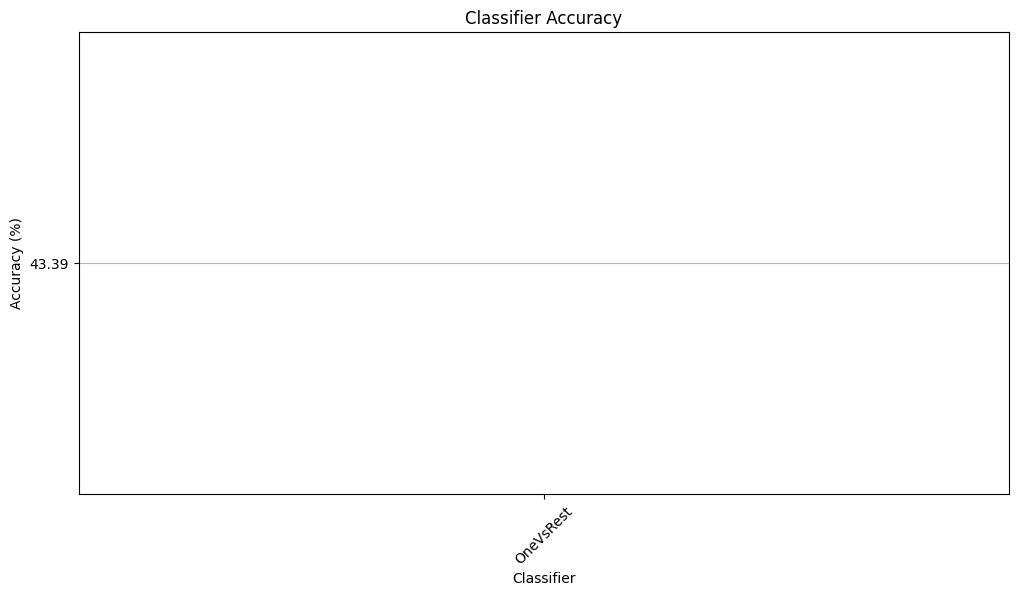

<ipython-input-23-e3dbd2155af5>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(20), x='Importance', y='Feature', palette='viridis')


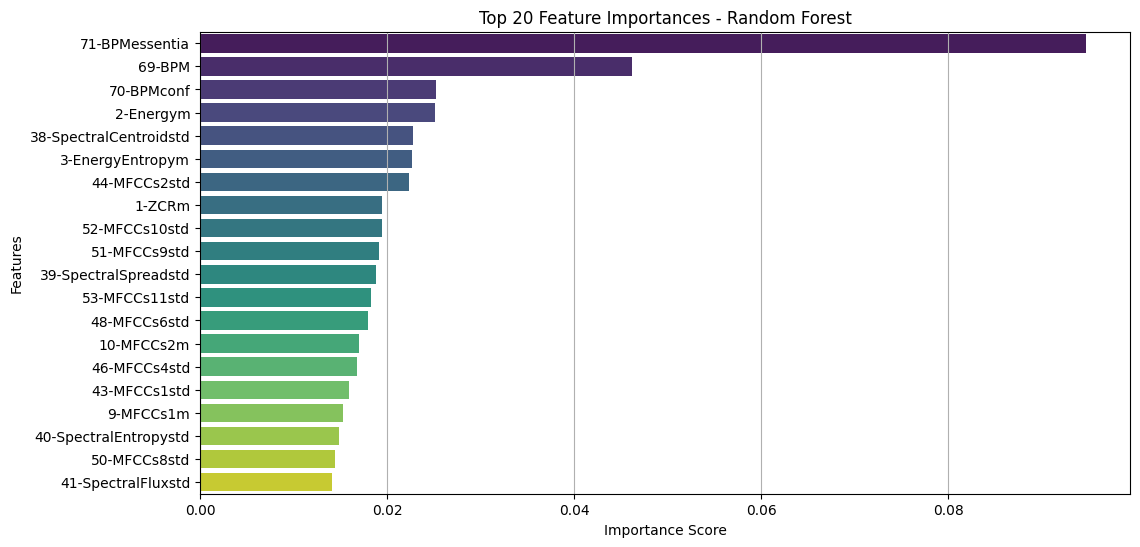

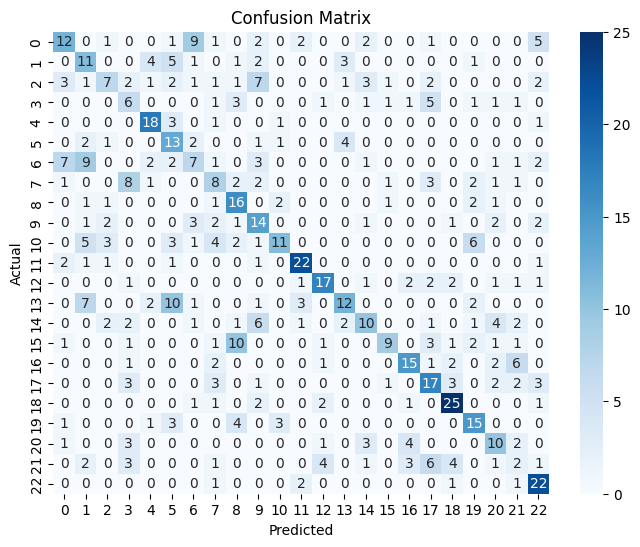

In [ ]:
# First, install necessary libraries if you haven't already
!pip install matplotlib seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'results' DataFrame contains your classifier results
results_pd = results.toPandas()  # Convert to Pandas DataFrame for visualization

# Plotting accuracy of classifiers
plt.figure(figsize=(12, 6))
sns.barplot(data=results_pd, x='Classifier', y='Result', palette='viridis')
plt.title('Classifier Accuracy')
plt.xlabel('Classifier')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Optional: Visualizing feature importance for tree-based classifiers
if 'RF_featureimportances' in globals():  # Check if Random Forest feature importances exist
    importances = RF_featureimportances
    feature_names = input_columns  # Assuming you have these from your earlier code
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance_df.head(20), x='Importance', y='Feature', palette='viridis')
    plt.title('Top 20 Feature Importances - Random Forest')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.grid(axis='x')
    plt.show()

# You can also explore confusion matrix for your best model
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions for the best model
predictions = OVR_BestModel.transform(test)

# Convert predictions to Pandas DataFrame
predictions_pd = predictions.select("label", "prediction").toPandas()

# Calculate confusion matrix
cm = confusion_matrix(predictions_pd['label'], predictions_pd['prediction'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(classes), yticklabels=range(classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Dataset Overview:
         Unnamed: 0       1-ZCRm    2-Energym  3-EnergyEntropym  \
count   2300.000000  2300.000000  2300.000000       2300.000000   
unique          NaN          NaN          NaN               NaN   
top             NaN          NaN          NaN               NaN   
freq            NaN          NaN          NaN               NaN   
mean    1149.500000     0.107736     0.104252          3.110511   
std      664.097131     0.037105     0.040966          0.070925   
min        0.000000     0.017122     0.004948          2.746105   
25%      574.750000     0.080967     0.075864          3.065538   
50%     1149.500000     0.107538     0.099977          3.117441   
75%     1724.250000     0.132890     0.128128          3.163833   
max     2299.000000     0.246659     0.281533          3.254153   

        4-SpectralCentroidm  5-SpectralSpreadm  6-SpectralEntropym  \
count           2300.000000        2300.000000         2300.000000   
unique                  NaN          

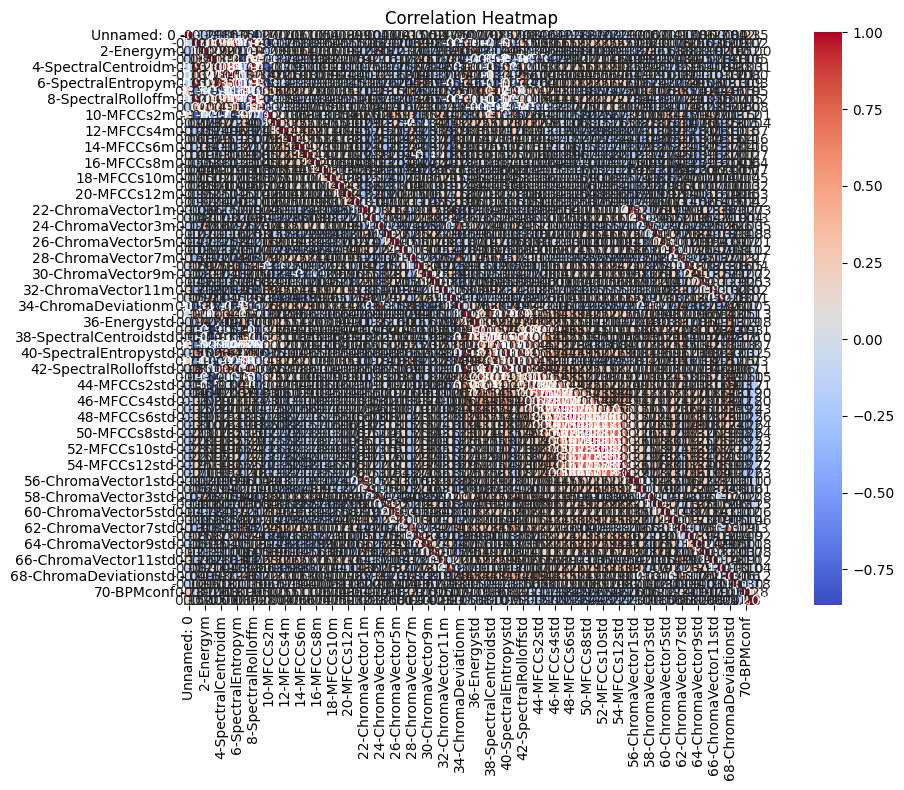

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the DataFrame from a CSV file (replace with your file path)
df_pd = pd.read_csv('/content/beatsdataset.csv')  # Replace 'your_file.csv' with your actual file path

# Check if DataFrame is loaded correctly
if df_pd.empty:
    print("The DataFrame is empty!")
else:
    print("Dataset Overview:")
    try:
        print(df_pd.describe(include='all'))  # Include all columns in summary
    except ValueError as e:
        print(f"Error describing the DataFrame: {e}")

    print("\nDataset Info:")
    print(df_pd.info())

    # Identify non-numeric columns
    non_numeric_columns = df_pd.select_dtypes(exclude=['number']).columns.tolist()
    print("Non-numeric columns:", non_numeric_columns)

    # 1. Check for missing values
    print("\nMissing Values in Each Column:")
    print(df_pd.isnull().sum())

    # 2. Correlation Heatmap (only for numeric columns)
    if df_pd.drop(columns=non_numeric_columns).empty:
        print("No numeric columns to calculate correlation.")
    else:
        plt.figure(figsize=(12, 8))
        correlation = df_pd.drop(columns=non_numeric_columns).corr()
        sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', square=True)
        plt.title('Correlation Heatmap')
        plt.tight_layout()
        plt.show()
